## Analytical Data Mining Project 

**Author:** Advait Ramesh Iyer **| NetID:** aiyer01 **| SUID:** 330623485

### Preprocessing

**Step 1:** Importing the essential libraries for the project

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Pre-processing
import glob
import random
import re
import nltk
# nltk.download('stopwords')
# !pip3 install stemming
from stemming.porter2 import stem
from nltk.corpus import stopwords
import string

# Spectral clustering
import numpy as np
import pandas as pd
import csv
import sklearn
from sklearn import cluster
import networkx as nx
import scipy
from scipy.sparse.linalg import eigs, eigsh
import matplotlib
from matplotlib import pylab
from matplotlib import pyplot as plt

# Community detection
import json

**Step 2:** Importing "Amazon co-purchased products" text file

In [0]:
filepath = glob.glob("./drive/My Drive/ADM Project/amazon-meta.txt*")
fil = filepath[0]
text = open(fil,'r',encoding='utf-8',errors='ignore')

**Step 3:** Conduct preprocessing of the data

In [0]:
amazon = {}
# Declaring the tuple of various feature values
(Id, ASIN, title, categories, group, connections, salesrank, tot_reviews, avg_rating, degree_centrality, clustering_coeff) = ("","","","","","", 0, 0, 0.0, 0, 0.0)

for line in text:
    line = line.strip()
    # Strip ID
    if(line.startswith("Id")):
        Id = line[3:].strip()
    # Strip ASIN, which is the node
    elif(line.startswith("ASIN")):
        ASIN = line[5:].strip()
    # Strip Title
    elif(line.startswith("title")):
        title = line[6:].strip()
        title = ' '.join(title.split())
    # Strip Group
    elif(line.startswith("group")):
        group = line[6:].strip()
    # Strip sales rank
    elif(line.startswith("salesrank")):
        salesrank = line[10:]
    # Strip similar, which are the connections
    elif(line.startswith("similar")):
        a = line.split()
        connections = ' '.join([i for i in a[2:]])
    # Strip categories
    elif(line.startswith("categories")):
        b = line.split()
        # Converted to lowercase
        categories = ' '.join((text.readline()).lower() for i in range(int(b[1].strip())))
        # Remove punctuations
        categories = re.compile('[%s]' % re.escape(string.digits + string.punctuation)).sub(' ', categories)
        # Remove stopwords
        categories = ' '.join(set(categories.split()) - set(stopwords.words('english')))
        # Concatenate the words
        categories = ' '.join(stem(word) for word in categories.split())
    # Count the reviews, and average rating
    elif(line.startswith("reviews")):
        c = line.split()
        tot_reviews = c[2].strip()
        avg_rating = c[7].strip()
    # Handling the exception for cases where instances are missing
    elif(line==""):
        try:
            exception = {}
            if(ASIN!=""):
                amazon[ASIN] = exception
            exception['Id'] = Id
            exception['title'] = title
            exception['group'] = group
            exception['categories'] = ' '.join(set(categories.split()))
            exception['connections'] = connections
            exception['salesrank'] = int(salesrank)
            exception['tot_reviews'] = int(tot_reviews)
            exception['avg_rating'] = float(avg_rating)
            exception['degree_centrality'] = degree_centrality
            exception['clustering_coeff'] = clustering_coeff
        except NameError:
            continue
        (Id, ASIN, title, categories, group, connections, salesrank, tot_reviews, avg_rating, degree_centrality, clustering_coeff) = ("","","","","","", 0, 0, 0.0, 0, 0.0)
text.close()

In [0]:
# Subset of music products in the dataset
amazon_music = {}
for key, value in amazon.items():
  # Check for the case where value is "Music", and only then choose
    if(value['group'] == "Music"):
        amazon_music[key] = amazon[key]

# Join the connections
for key, value in amazon_music.items():
    amazon_music[key]['connections'] = ' '.join([connection for connection in value['connections'].split() if connection in amazon_music.keys()])

# Convert to dataframe
amazon_music_df = pd.DataFrame.from_dict(amazon_music)
amazon_music_df = amazon_music_df.transpose()

In [23]:
len(amazon_music_df)

103144

In [0]:
# Subset of books
amazon_books = {}
for key, value in amazon.items():
    if(value['group'] == "Book"):
        amazon_books[key] = amazon[key]

for key, value in amazon_books.items():
    amazon_books[key]['connections'] = ' '.join([connection for connection in value['connections'].split() if connection in amazon_books.keys()])
    
amazon_books_df = pd.DataFrame.from_dict(amazon_books)
amazon_books_df = amazon_books_df.transpose()

In [24]:
len(amazon_books_df)

393561

In [0]:
# Subset of DVDs
amazon_dvd = {}
for key, value in amazon.items():
    if(value['group'] == "DVD"):
        amazon_dvd[key] = amazon[key]

for key, value in amazon_dvd.items():
    amazon_dvd[key]['connections'] = ' '.join([connection for connection in value['connections'].split() if connection in amazon_dvd.keys()])

amazon_dvd_df = pd.DataFrame.from_dict(amazon_dvd)
amazon_dvd_df = amazon_dvd_df.transpose()

In [25]:
len(amazon_dvd_df)

19828

In [0]:
# Subset of Videos
amazon_video = {}
for key, value in amazon.items():
    if(value['group'] == "Video"):
        amazon_video[key] = amazon[key]

for key, value in amazon_video.items():
    amazon_video[key]['connections'] = ' '.join([connection for connection in value['connections'].split() if connection in amazon_video.keys()])

amazon_video_df = pd.DataFrame.from_dict(amazon_video)
amazon_video_df = amazon_video_df.transpose()

In [26]:
len(amazon_video_df)

26131

In [0]:
# Evaluating the similarity between two connected nodes
connections_graph = nx.Graph()
# Add the nodes
for key, value in amazon.items():
  connections_graph.add_node(key)
  for i in value['connections'].split():
    # Add the respective connected nodes
    connections_graph.add_node(i.strip())
    similarity = 0
    try:
      # Set of words in the node's categorical description
      set_1 = set(amazon[key]['categories'].split())
      # Set of words is node's connections' categorical description
      set_2 = set(amazon[i]['categories'].split())
    except KeyError:
      continue
    # Calculating intersection and union
    union = set_1 & set_2
    intersection = set_1 | set_2
    if(len(union)) > 0:
      # Similarity is the ratio of intersection with union. The more common items, the higher the intersection, and similarity
      similarity = round(len(intersection)/len(union),2)
    connections_graph.add_edge(key, i.strip(), weight=similarity)

In [0]:
# Adjacency matrix
A = nx.adjacency_matrix(connections_graph)

In [0]:
# Laplacian matrix
L = nx.laplacian_matrix(connections_graph)

In [0]:
# Due to the large size of the data, computing only top 200 eigenvalues/eigenvectors
eigenvalues, eigenvectors = eigsh(L, k=200, which='LM', return_eigenvectors=True)

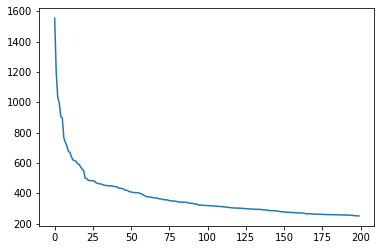

In [17]:
# Sorting the eigenvectors on the basis of sorted eigenvalues' keys
ids = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[ids]
plt.plot(eigenvalues)

eigenvectors = eigenvectors[:, ids]

Through visual inspection, 25 eigenvectors seem to cover most of the variance of the graph.

We do not possess any objective ground truth to evaluate spectral clustering results.

Using the text data, similarity was computed to calculate the clustering coefficient.

In [0]:
# Choosing the first 25 eigenvectors only
new_eig = eigenvectors[0:25]

# K-means clustering with the motivation of splitting to 4 groups
kmeans_clustering=cluster.KMeans(n_clusters=4)
kmeans_clustering.fit(new_eig)
clusters=kmeans_clustering.labels_

In [51]:
# Cluster labels
clusters

array([0, 0, 0, 0, 0, 0, 0, 3, 1, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2], dtype=int32)

In [18]:
# Evaluating the degree of the nodes of connections
deg_central = nx.degree(connections_graph)
for key in nx.nodes(connections_graph):
  try:
    value = amazon[key]
  except KeyError:
    continue
  # Degree centrality is the integer value of deg_central
  value['degree_centrality'] = int(deg_central[key])
  # 
  ego = nx.ego_graph(connections_graph, key, radius=1)
  # Evaluating the clustering coefficient by 
  value['clustering_coeff'] = round(nx.average_clustering(ego),2)
  amazon[key] = value

# Printing the weights of each of each 150th node
count = 0
for f,t,e in connections_graph.edges(data=True):
  if count == 150:
    break
  print(e['weight'])
  count +=1

1.43
2.0
1.25
1.25
1.43
1.43
1.43
1.43
1.43
1.33
1.0
1.11
1.29
2.57
2.0
2.57
1.67
3.0
1.29
1.0
2.2
1.11
1.0
1.29
1.57
1.43
1.29
1.11
1.11
1.57
1.67
1.29
1.57
1.57
2.29
1.29
1.0
1.0
2.0
2.5
4.4
3.57
2.25
2.29
2.11
2.12
3.83
2.57
2.25
2.57
1.46
1.07
2.29
4.8
3.0
2.29
7.33
3.0
2.57
3.17
2.57
2.25
1.2
1.25
1.71
10.0
1.25
1.0
1.43
1.43
1.71
1.43
3.6
1.62
2.14
1.11
1.11
2.4
1.71
1.71
1.43
1.44
2.17
2.14
2.33
1.57
1.75
2.88
1.88
2.0
1.38
3.25
6.0
2.5
1.75
2.36
1.14
1.14
1.0
1.27
10.5
1.15
2.09
1.23
1.42
1.33
5.4
10.33
2.91
2.55
2.45
2.09
2.09
2.55
2.36
2.09
6.17
3.11
3.22
2.36
3.8
1.07
1.36
1.23
1.69
2.22
4.0
1.45
1.14
1.31
1.58
1.14
1.18
1.45
1.82
2.78
1.27
1.0
1.11
1.11
1.11
1.11
1.11
1.79
1.62
1.11
1.11
1.11
1.17
1.11


In [0]:
# Saving the edgelist
writer = open('amazon_edgelist.txt','w',encoding='utf-8',errors='ignore')
writer.write("Id\t" + "ASIN\t" + "title\t" + "group\t" + "categories\t" + "connections\t" + "salesrank\t" + "tot_reviews\t" + "avg_rating\t" + "degree_centrality\t" + "clustering_coeff\n")
for key, value in amazon.items():
  writer.write(value['Id']+"\t"+key+"\t"+value['title']+"\t"+value["group"]+"\t"+value["categories"]+"\t"+value["connections"]+"\t"+str(value["salesrank"])+"\t"+str(value["tot_reviews"])+"\t"+str(value["avg_rating"])+"\t"+str(value["degree_centrality"])+"\t"+str(value["clustering_coeff"]))

writer.close()

In [0]:
# Saving the edgelist's associated graph
writer = open("amazon_edgelist","wb")
nx.write_weighted_edgelist(connections_graph, writer)

In [0]:
items = list(amazon.items())

In [0]:
# Converting the dictionary into a dataframe
ls = []
for i, j in enumerate(items):
    colnames = list(j[1])
    colnames.append("ASIN")
    vals = list(j[1].values())
    vals.append(j[0])
    ls.append(vals)
df = pd.DataFrame(ls, columns=colnames)

In [0]:
### Regression Models

In [0]:
# Choosing salesrank, total reviews, average rating, degree centrality, and clustering coefficient columns
# df.head()
df_new = df[["salesrank","tot_reviews","avg_rating","degree_centrality","clustering_coeff"]]
for i in range(len(df_new['salesrank'])):
    if df_new['salesrank'][i] == 0:
        df_new = df_new.drop(i)
df_new.head()

,salesrank,tot_reviews,avg_rating,degree_centrality,clustering_coeff
1,396585,2,5.0,8,0.80
2,168596,12,4.5,9,0.85
3,1270652,1,5.0,0,0.00
4,631289,1,4.0,6,0.79
5,455160,0,0.0,4,1.00


In [0]:
clustering_coeff_sorted = df.sort_values('clustering_coeff', ascending=False)

In [65]:
print(clustering_coeff_sorted[['title','group']][0:10])

                                                    title  group
494386            Corporate Finance: A Valuation Approach   Book
217709  When the Horses Came : The Horse Catcher's Tri...   Book
217740                                    Hidden Beauties    DVD
217735                   Crossing to Safety (Great Reads)   Book
471969                   Banners on Favorite Bible Verses   Book
440294  The Rorschach: A Comprehensive System, Vol 1: ...   Book
296827      Treehouses (The House That Jack Built Series)   Book
38244                 Mendelssohn: Piano Trios Nos. 1 & 2  Music
79597                                             So What  Music
471965    Atmosphere, The: An Introduction to Meteorology   Book


In [0]:
degree_centrality_sorted = df.sort_values('degree_centrality', ascending=False)

In [67]:
print(degree_centrality_sorted[["title",'group']][0:10])

                                                    title group
458358  Diagnostic and Statistical Manual of Mental Di...  Book
222074  Publication Manual of the American Psychologic...  Book
548091                                              Laura   DVD
199628                                   The Great Gatsby  Book
515301  1001 Most Useful Spanish Words (Beginners' Gui...  Book
502784           Brown Bear, Brown Bear, What Do You See?  Book
291117                                           It Works  Book
296016  Easy Spanish Phrase Book: Over 770 Basic Phras...  Book
239107                                         The Prince  Book
239327              Confessions (Oxford World's Classics)  Book


In [0]:
# Train test split
train, test = df_new.sample(frac=0.6), df_new.sample(frac=0.4) 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ec50b53c8>,
      dtype=object)

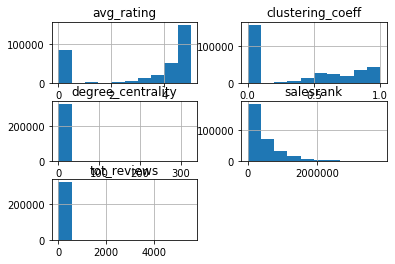

In [0]:
train.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ebc05c908>,
      dtype=object)

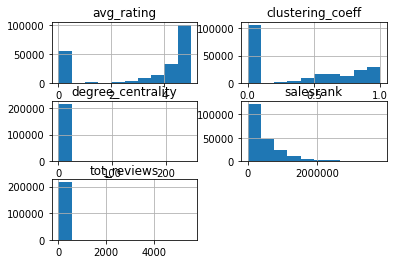

In [0]:
test.hist()

In [0]:
# Splitting the training data, and the label column
X_train = train[["tot_reviews","avg_rating","degree_centrality","clustering_coeff"]]
Y_train = train[["salesrank"]]
print(len(train))
print(len(X_train))
print(len(Y_train))

X_test = test[["tot_reviews","avg_rating","degree_centrality","clustering_coeff"]]
Y_test = test[["salesrank"]]
print(len(test))
print(len(X_test))
print(len(Y_test))

325586
325586
325586
217057
217057
217057


In [0]:
# Normalized linear regression
lr = sklearn.linear_model.LinearRegression(normalize=True)
lr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [0]:
# Prediction in test set
prediction_lr = lr.predict(X_test)

Linear regression train score =  0.24697647850232307
Linear regression train score =  0.2489601601273278
Intercept =  937566.9118967386
Coefficient of Total Reviews =  -238.1807167117478
Coefficient of Average Rating =  -82872.21391232984
Coefficient of Degree Centrality = -17364.80767812834
Coefficient of Clustering Coefficient = -306236.5122249591


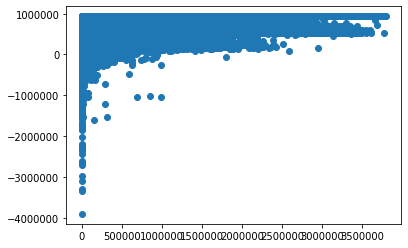

In [0]:
intercept_lr = lr.intercept_
coeff_lr = lr.coef_
print("Linear regression train score = ", lr.score(X_train,Y_train))
print("Linear regression test score = ", lr.score(X_test,Y_test))
print("Intercept = ",intercept_lr[0])
print("Coefficient of Total Reviews = ",coeff_lr[0][0])
print("Coefficient of Average Rating = ",coeff_lr[0][1])
print("Coefficient of Degree Centrality =",coeff_lr[0][2])
print("Coefficient of Clustering Coefficient =",coeff_lr[0][3])

plt.scatter(Y_test, prediction_lr)

In [0]:
# Normalized ridge regression
ridge = sklearn.linear_model.Ridge(alpha=0.05, normalize=False)
ridge.fit(X_train, Y_train)

Ridge(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [0]:
# Prediction through ridge regression
prediction_ridge = ridge.predict(X_test)

Ridge regression train score =  0.24697647850226703
Ridge regression test score =  0.24896016128793197
Intercept =  937566.8403256098
Coefficient of Total Reviews =  -238.18076650130314
Coefficient of Average Rating =  -82872.2242474601
Coefficient of Degree Centrality = -17364.82004800917
Coefficient of Clustering Coefficient = -306236.1261793769


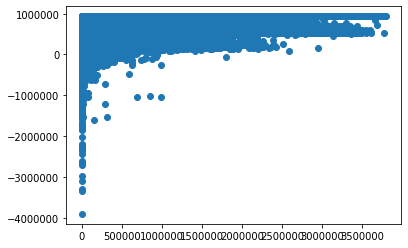

In [0]:
intercept_ridge = ridge.intercept_
coeff_ridge = ridge.coef_
print("Ridge regression train score = ", ridge.score(X_train,Y_train))
print("Ridge regression test score = ", ridge.score(X_test,Y_test))
print("Intercept = ",intercept_ridge[0])
print("Coefficient of Total Reviews = ",coeff_ridge[0][0])
print("Coefficient of Average Rating = ",coeff_ridge[0][1])
print("Coefficient of Degree Centrality =",coeff_ridge[0][2])
print("Coefficient of Clustering Coefficient =",coeff_ridge[0][3])

plt.scatter(Y_test, prediction_ridge)

In [0]:
# Lasso regression
lasso = sklearn.linear_model.Lasso(alpha=0.05, normalize=True)
lasso.fit(X_train, Y_train)

Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
# Prediction with lasso regression
prediction_lasso = lasso.predict(X_test)

Lasso regression train score =  0.2469764720983473
Lasso regression test score =  0.2489601065941861
Intercept =  [937507.53455197]
Coefficient of Total Reviews =  -237.86455005397832
Coefficient of Average Rating =  -82862.67733426749
Coefficient of Degree Centrality = -17361.887266029447
Coefficient of Clustering Coefficient = -306200.10081795935


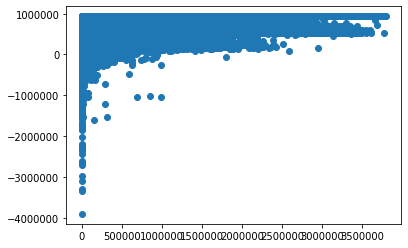

In [0]:
intercept_lasso = lasso.intercept_
coeff_lasso = lasso.coef_
print("Lasso regression train score = ", lasso.score(X_train,Y_train))
print("Lasso regression test score = ", lasso.score(X_test,Y_test))
print("Intercept = ",intercept_lasso)
print("Coefficient of Total Reviews = ",coeff_lasso[0])
print("Coefficient of Average Rating = ",coeff_lasso[1])
print("Coefficient of Degree Centrality =",coeff_lasso[2])
print("Coefficient of Clustering Coefficient =",coeff_lasso[3])

plt.scatter(Y_test, prediction_lasso)

Lasso model provides us the insight that Degree Centrality and Clustering Coefficient don't possess much weight in the regression model, and hence can be removed.

In [0]:
# Removing clustering coefficient and degree centrality from the dataset
X_train_new = X_train[["tot_reviews","avg_rating"]]
X_test_new = X_test[["tot_reviews","avg_rating"]]

In [0]:
# Normalized Linear Regression
lr_new = sklearn.linear_model.LinearRegression(normalize=True)
lr_new.fit(X_train_new, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [0]:
prediction_lr_new = lr_new.predict(X_test_new)

Linear regression train score =  0.15522516907798012
Linear regression test score =  0.15691777694894482
Intercept =  846548.6333880492
Coefficient of Total Reviews =  -449.9864696841365
Coefficient of Average Rating =  -109209.60445485623


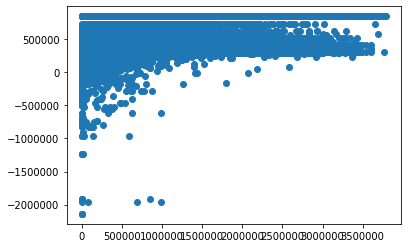

In [0]:
intercept_lr_new = lr_new.intercept_
coeff_lr_new = lr_new.coef_
print("Linear regression train score = ", lr_new.score(X_train_new,Y_train))
print("Linear regression test score = ", lr_new.score(X_test_new,Y_test))
print("Intercept = ",intercept_lr_new[0])
print("Coefficient of Total Reviews = ",coeff_lr_new[0][0])
print("Coefficient of Average Rating = ",coeff_lr_new[0][1])

plt.scatter(Y_test, prediction_lr_new)

The accuracy does not seem to increase more, so we stop the regression experiment. 

The key conclusion is that clustering and degree metrics play no role in the regression model.

**Girvan Newman Algorithm**

In [0]:
# Transformation of DVD subset into graph
connections_dvd_graph = nx.Graph()
for key, value in amazon_dvd.items():
  connections_dvd_graph.add_node(key)
  for i in value['connections'].split():
    connections_dvd_graph.add_node(i.strip())
    similarity = 0
    try:
      set_1 = set(amazon_dvd[key]['categories'].split())
      set_2 = set(amazon_dvd[i]['categories'].split())
    except KeyError:
      continue
    union = set_1 & set_2
    intersection = set_1 | set_2
    if(len(union)) > 0:
      similarity = round(len(intersection)/len(union),2)
    connections_dvd_graph.add_edge(key, i.strip(), weight=similarity)

In [0]:
# Generator object of communities through Girvan Newman algorithm
communities_dvd = nx.algorithms.community.girvan_newman(connections_dvd_graph)

In [0]:
# First community
communities_newman = next(communities_dvd)

In [0]:
# Evaluating the modularity of the algorithm
modularity_newman_new = nx.algorithms.community.modularity(connections_dvd_graph, communities_newman)

In [0]:
# Finding the optimal modularity, and the count
modularity_newman_old = 0.00001
count = 0
while modularity_newman_new > modularity_newman_old:
  modularity_newman_old = modularity_newman_new
  communities_newman_final = communities_newman
  communities_newman = next(communities)
  modularity_newman_new = nx.algorithms.community.modularity(connections_dvd_graph, communities_newman)
  count +=1